# Chapter 14 - Deep Computer Vision using Convolutional Neural Networks

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [3]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

In [4]:
# Common imports
import numpy as np
import os

In [5]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale and RGB images:

In [7]:
def plot_image(image):
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')
    
def plot_color_image(image):
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')

## What is a Convolution?

In [8]:
import numpy as np
from sklearn.datasets import load_sample_image

In [9]:
# Load sample images
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
images.shape

(2, 427, 640, 3)

In [10]:
batch_size, height, width, channels = images.shape

In [11]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

In [12]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

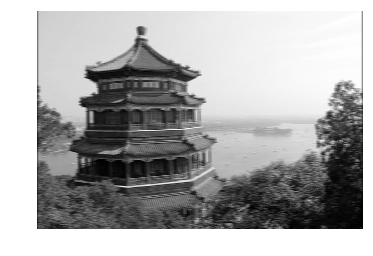

In [13]:
plt.imshow(outputs[0, :, :, 1], cmap='gray') # plot the 1st image's 2nd feature map
plt.axis('off')
plt.show()

In [14]:
def crop(images):
    return images[150:220, 130:250]

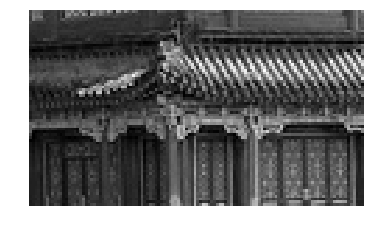

In [15]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

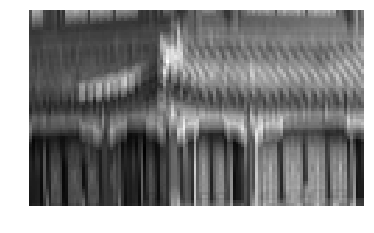

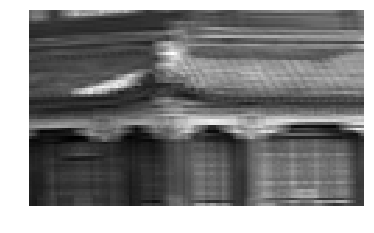

In [16]:
for feature_map_index, filename in enumerate(['china_vertical', 'china_horizontal']):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

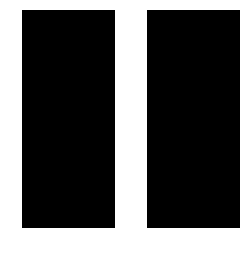

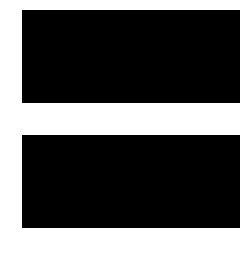

In [17]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## Convolutional Layers

Using `keras.layers.Conv2D()`:

In [18]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding='SAME', activation='relu')

## SAME vs VALID padding

In [19]:
def feature_map_size(input_size, kernel_size, strides=1, padding='SAME'):
    if padding == 'SAME':
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [20]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [21]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

Using "`SAME`" padding is equivalent to padding manually using `manual_same_padding()` then using "`VALID`" padding (confusingly, "`VALID`" padding means no padding at all):

In [22]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

In [23]:
valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

In [24]:
# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

In [25]:
# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

In [26]:
same_output = conv_same(images.astype(np.float32))

In [27]:
assert np.allclose(valid_output.numpy(), same_output.numpy())

## Pooling Layers

### Max Pooling

In [28]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [29]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

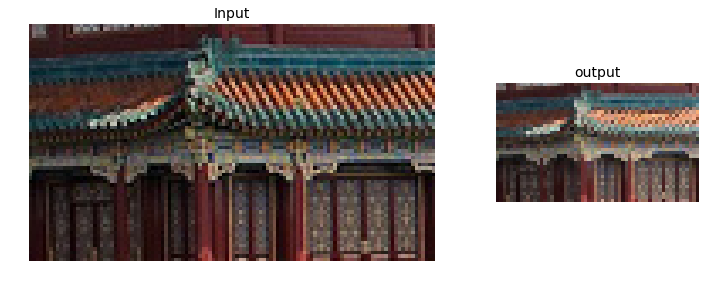

In [30]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Input', fontsize=14)
ax1.imshow(cropped_images[0]) # plot the 1st image
ax1.axis('off')

ax1 = fig.add_subplot(gs[0, 1])
ax1.set_title('output', fontsize=14)
ax1.imshow(output[0]) # plot the 1st image
ax1.axis('off')

plt.show()

### Depth-wise Pooling

In [31]:
class DepthMaxPool(keras.layers.Layer):
    
    def __init__(self, pool_size, strides=None, padding='VALID', **kwarg):
        super().__init__(**kwarg)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [32]:
depth_pool = DepthMaxPool(3)

with tf.device('/cpu:0'):
    depth_output = depth_pool(cropped_images)
    
depth_output.shape

TensorShape([2, 70, 120, 1])

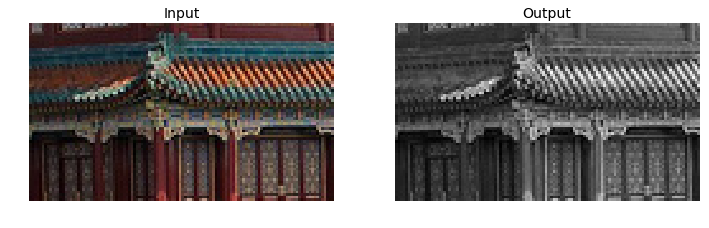

In [33]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

### Average Pooling

In [34]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [35]:
output_avg = avg_pool(cropped_images)

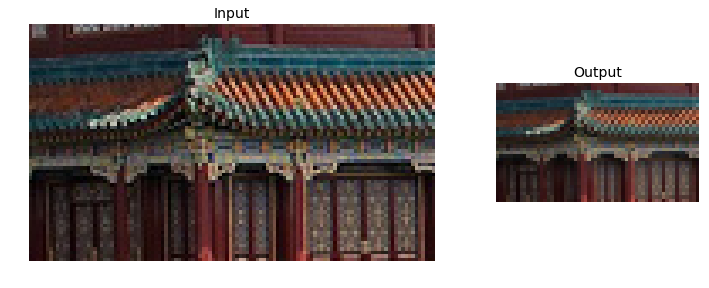

In [36]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")

plt.show()

### Global Avegrage Pooling

In [37]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: id=120, shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

In [38]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: id=124, shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

## Tackling Fashion MNIST with a CNN

In [39]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [40]:
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [41]:
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True)

X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

In [42]:
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [43]:
X_train[0].shape

(28, 28, 1)

In [44]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3,
                        activation='relu',
                        padding='SAME')

In [45]:
model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7,
                  input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax')
])

In [46]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

In [46]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 224s 4ms/sample - loss: 0.7232 - accuracy: 0.7449 - val_loss: 0.3871 - val_accuracy: 0.8674
Epoch 2/10
55000/55000 [==============================] - 233s 4ms/sample - loss: 0.4265 - accuracy: 0.8560 - val_loss: 0.3574 - val_accuracy: 0.8720
Epoch 3/10
55000/55000 [==============================] - 218s 4ms/sample - loss: 0.3669 - accuracy: 0.8753 - val_loss: 0.2957 - val_accuracy: 0.8956
Epoch 4/10
55000/55000 [==============================] - 226s 4ms/sample - loss: 0.3303 - accuracy: 0.8876 - val_loss: 0.3446 - val_accuracy: 0.8856
Epoch 5/10
55000/55000 [==============================] - 246s 4ms/sample - loss: 0.3188 - accuracy: 0.8929 - val_loss: 0.2888 - val_accuracy: 0.8960
Epoch 6/10
55000/55000 [==============================] - 235s 4ms/sample - loss: 0.2948 - accuracy: 0.9004 - val_loss: 0.2951 - val_accuracy: 0.8996
Epoch 7/10
55000/55000 [===========================

In [47]:
score = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 11s 1ms/sample - loss: 0.3089 - accuracy: 0.8981


In [48]:
X_new = X_test[:10] # pretend we have new images

In [49]:
y_pred = model.predict(X_new)

## ResNet-34

In [47]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3,
                        strides=1,
                        padding='SAME',
                        use_bias=False)

In [53]:
class ResidualUnit(keras.layers.Layer):
    
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]
            
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [54]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64,
                        kernel_size=7,
                        strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=3, 
                                    strides=2,
                                    padding='SAME'))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
    
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_v2_9 (Ba (None, 112, 112, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_4 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_5 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_6 (ResidualUni (None, 56, 56, 64)       

## Using Pretrained Models from Keras

In [56]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 16s 0us/step


In [57]:
images.shape

(2, 427, 640, 3)

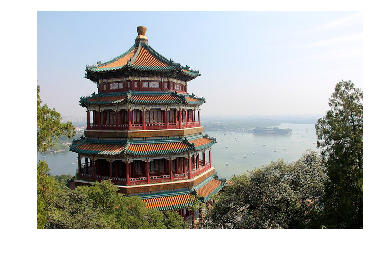

In [58]:
plot_color_image(images[0])

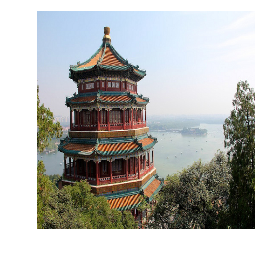

In [59]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

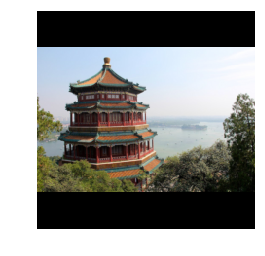

In [63]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])
plt.show()

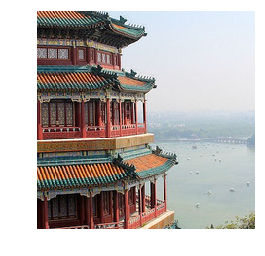

In [64]:
images_resized = tf.image.resize_image_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

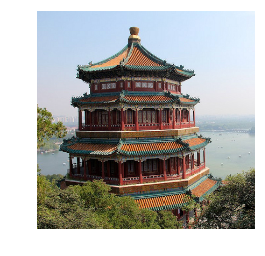

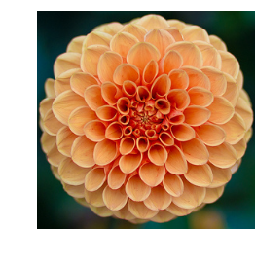

In [65]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]

images_resized = tf.image.crop_and_resize(images, 
                                          [china_box, flower_box], 
                                          [0, 1],
                                          [224, 224])

plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

Preprocessing inputs:

In [66]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

Now we can use the pretrained model to make predictions:

In [67]:
Y_proba = model.predict(inputs)

In [68]:
Y_proba.shape

(2, 1000)

### Top-K Predictions:

In [69]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)

for image_index in range(len(images)):
    print('Image #{}'.format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print(' {} - {:12s} {:.2f}%'.format(class_id, name, y_proba*100))
    print()

40960/35363 [==================================] - 0s 6us/step
Image #0
 n03877845 - palace       42.87%
 n02825657 - bell_cote    40.57%
 n03781244 - monastery    14.56%

Image #1
 n04522168 - vase         46.83%
 n07930864 - cup          7.78%
 n11939491 - daisy        4.87%



## Pretrained Models for Transfer Learning

In [70]:
import tensorflow_datasets as tfds

In [71]:
dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



A Jupyter Widget



Dataset tf_flowers downloaded and prepared to /Users/dongdongdongdong/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [72]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [73]:
info.splits['train']

<tfds.core.SplitInfo num_examples=3670>

In [74]:
class_names = info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [76]:
n_classes = info.features['label'].num_classes
n_classes

5

In [77]:
dataset_size = info.splits['train'].num_examples
dataset_size

3670

### Spliting the Dataset for Validation and Test:

In [79]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    'tf_flowers',
    split=['train[:10%]', 'train[10%:25%]', 'train[25%:]'],
    as_supervised=True)

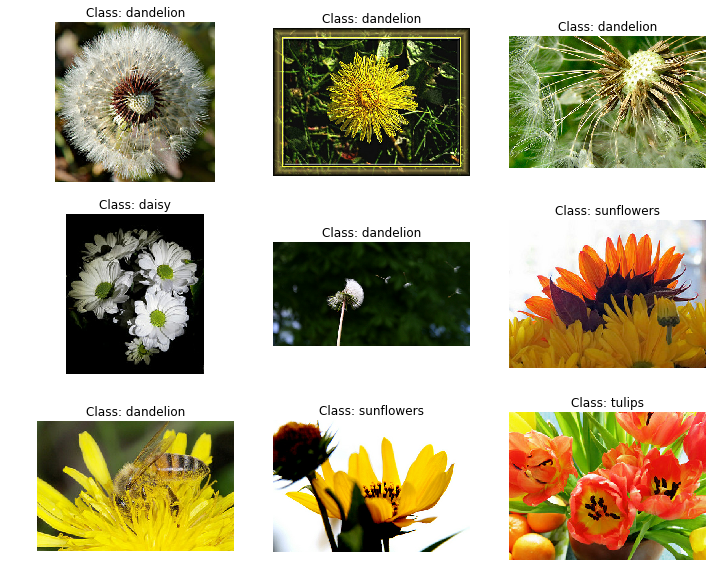

In [80]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title('Class: {}'.format(class_names[label]))
    plt.axis('off')
    
plt.show()

### Preprocessing:

In [82]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Slightly fancier preprocessing (but you could add much more data augmentation):

In [83]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop : bottom_crop, left_crop : right_crop]

In [84]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

In [85]:
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_images = random_crop(image)
        cropped_images = tf.image.random_flip_left_right(cropped_images)
    else:
        cropped_images = central_crop(image)
    resized_image = tf.image.resize(cropped_images, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [86]:
batch_size = 32

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)

valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)

test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

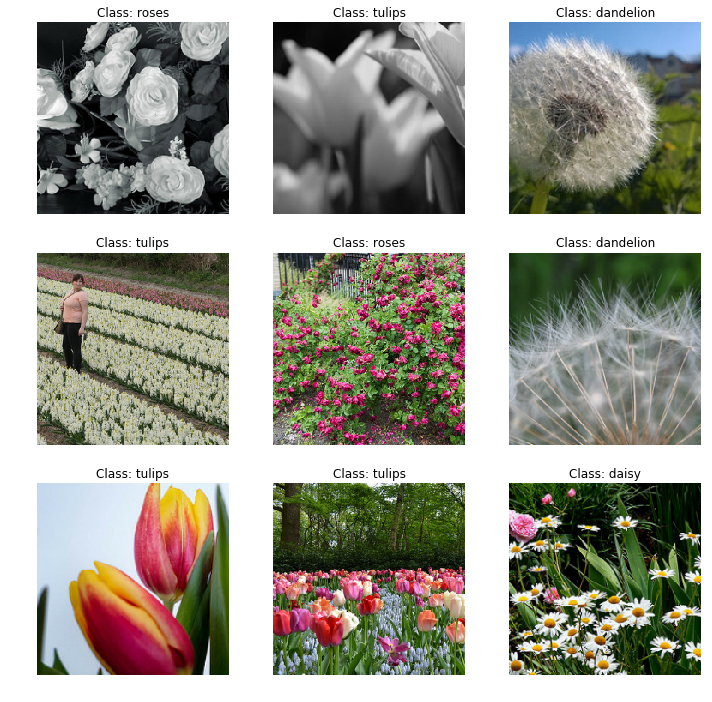

In [87]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index+1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title('Class: {}'.format(class_names[y_batch[index]]))
        plt.axis('off')
        
plt.show()

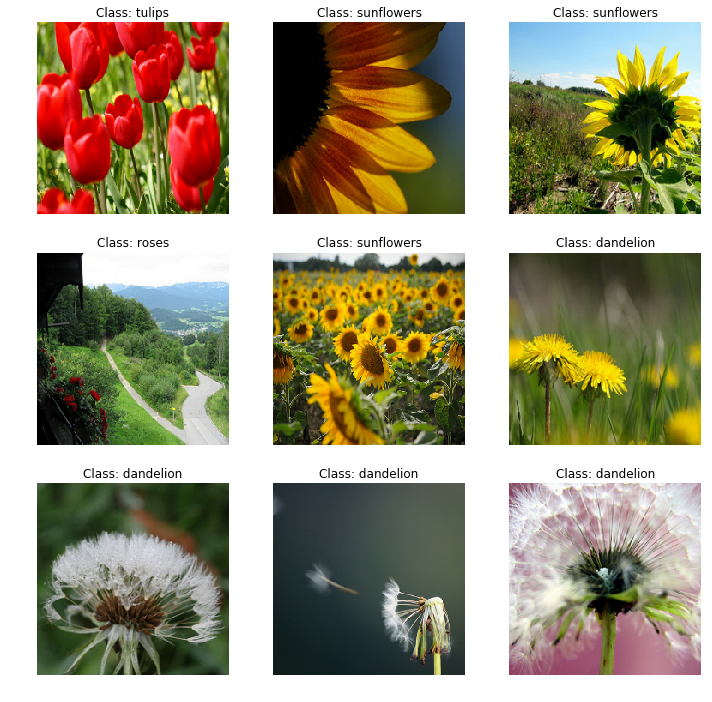

In [88]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

Now let's load an Xception model, pretrained on ImageNet:

In [90]:
base_model = keras.applications.xception.Xception(weights='imagenet',
                                                  include_top=False)

83689472/83683744 [==============================] - 12s 0us/step


In [91]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes,
                            activation='softmax')(avg)

In [93]:
model = keras.models.Model(inputs=base_model.input,
                           outputs=output)

In [94]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_54
13 block2_pool
14 batch_normalization_v1
15 add_16
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_55
23 block3_pool
24 batch_normalization_v1_1
25 add_17
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_56
33 block4_pool
34 batch_normalization_v1_2
35 add_18
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_19
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52

Freeze the weights of the pretrained layers:

In [96]:
for layer in base_model.layers:
    layer.trainable = False

Finally, we can compile the model and start training:

In [97]:
optimizer = keras.optimizers.SGD(lr=0.2, 
                                 momentum=0.9,
                                 decay=0.01)

In [98]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [99]:
history = model.fit(train_set,
                    epochs=3,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size))

Epoch 1/3
86/86 [==============================] - 286s 3s/step - loss: 0.6642 - accuracy: 0.7809 - val_loss: 1.3538 - val_accuracy: 0.7739
Epoch 2/3
86/86 [==============================] - 289s 3s/step - loss: 0.3910 - accuracy: 0.8714 - val_loss: 1.3005 - val_accuracy: 0.7702
Epoch 3/3
86/86 [==============================] - 286s 3s/step - loss: 0.3371 - accuracy: 0.8866 - val_loss: 1.2433 - val_accuracy: 0.7537


After training the model for a few epochs, its validation accuracy should reach about 75-80% amd stop making progress. This means that the top layers are now pretty well trained, so we are ready to unfreeze all the layers (or you could try unfreezing just the top ones) and continue training (don't forget to compile the model when you freeze or unfreeze layers).

In [100]:
for layer in base_model.layers:
    layer.trainable = True

This time we use a much lower learning rate to avoid damaging the pretrained weights:

In [101]:
optimizer = keras.optimizers.SGD(lr=0.01,
                                 momentum=0.9,
                                 nesterov=True,
                                 decay=0.001)

In [102]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [104]:
history = model.fit(train_set,
                    epochs=2,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size))

Epoch 1/2
86/86 [==============================] - 1224s 14s/step - loss: 0.2240 - accuracy: 0.9190 - val_loss: 0.5391 - val_accuracy: 0.8787
Epoch 2/2
86/86 [==============================] - 1120s 13s/step - loss: 0.1088 - accuracy: 0.9600 - val_loss: 0.6483 - val_accuracy: 0.8695


## Classification and Localization

In [106]:
base_model = keras.applications.xception.Xception(weights='imagenet',
                                                 include_top=False)

In [107]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

class_output = keras.layers.Dense(n_classes, 
                                  activation='softmax')(avg)

loc_output = keras.layers.Dense(4)(avg)

In [108]:
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])

In [109]:
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [122]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

In [123]:
fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [124]:
model.fit(fake_train_set,
          epochs=2,
          steps_per_epoch=5)

Epoch 1/2
5/5 [==============================] - 69s 14s/step - loss: 1.2514 - dense_5_loss: 1.4919 - dense_6_loss: 0.2891 - dense_5_accuracy: 0.3688 - dense_6_accuracy: 0.2438
Epoch 2/2
5/5 [==============================] - 66s 13s/step - loss: 1.0036 - dense_5_loss: 1.2058 - dense_6_loss: 0.1948 - dense_5_accuracy: 0.7000 - dense_6_accuracy: 0.2625


## Mean Average Precision (mAP)

In [126]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

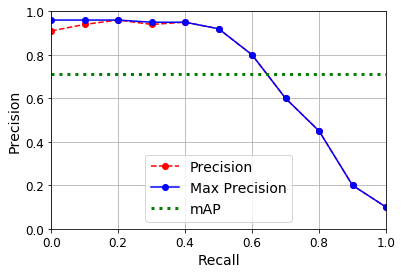

In [127]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()

plt.plot(recalls, precisions, 'ro--', label='Precision')
plt.plot(recalls, max_precisions, 'bo-', label='Max Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot([0, 1], [mAP, mAP], 'g:', linewidth=3, label='mAP')
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc='lower center', fontsize=14)
plt.show()

## Transpose Convolutions

In [135]:
tf.random.set_seed(42)
X = images_resized.numpy()

In [136]:
X.shape

(2, 224, 224, 3)

In [137]:
conv_transpose = keras.layers.Conv2DTranspose(filters=5,
                                              kernel_size=3,
                                              strides=2,
                                              padding='VALID')

In [138]:
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

In [139]:
def normalize(X):
    return (X - tf.reduce_mean(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Input', fontsize=14)
ax1.imshow(X[0]) # plot the 1st image
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Output', fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]),
           interpolation='bicubic') # plot the output for the 1st image
ax2.axis('off')

plt.show()

In [144]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:, 
             kernel_size - 1 : (height - 1) * stride + kernel_size : stride,
             kernel_size - 1 : (width - 1) * stride + kernel_size : stride,
             :] = images
    return upscaled

In [145]:
upscaled = upscale_images(X, stride=2, kernel_size=3)

In [146]:
weights, biases = conv_transpose.weights

In [147]:
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, 
                             filters=reversed_filters, 
                             strides=1,
                             padding='VALID')

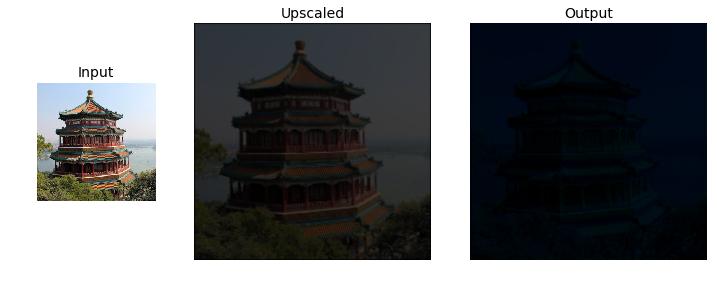

In [148]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Input', fontsize=14)
ax1.imshow(X[0]) # plot the 1st image
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Upscaled', fontsize=14)
ax2.imshow(upscaled[0],
           interpolation='bicubic') # upscaled
ax2.axis('off')

ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title('Output', fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]),
           interpolation='bicubic') # output
ax3.axis('off')

plt.show()

In [149]:
np.allclose(output, manual_output.numpy(), atol=1e-7)

True